# Automated visual area segmentation

In this notebook, we explore one potential application of our toolbox for automated segmentation of early visual areas. To do so, we will leverage a [Bayesian model of retinotopy](https://elifesciences.org/articles/40224), which combines anatomical priors with empirical observations to generate individual-specific visual area boundaries. The model uses a retinotopic template (prior) and retinotopic maps derived from some minutes of fMRI data (observation) to produce visual area segmentation. Here, we show that retinotopic maps predicted with our toolbox can replace empirically derived maps and can be used within this Bayesian framework for obtaining early visual area parcels.

We will perform the following steps:
1. Generate required files for the Bayesian model of retinotopy;
2. Run the Bayesian model of retinotopy to estimate visual area boundaries;
3. Prepare [manually drawn visual area labels](https://osf.io/gqnp8/) for comparisons;
4. Compare automatically derived segmentations using either the empirically estimated or the predicted retinotopic maps as observations with the manually determined segmentations;

## Import libraries and functions

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import sys
import os
import scipy
import os.path as osp
# import h5py
import shutil
import seaborn as sns

sys.path.append('..')

from functions.visualization import retinotopic_map_plot
from deepRetinotopy_TheToolbox.utils.rois import ROI_WangParcelsPlusFovea as roi
from functions.datasets import RetinotopyData_training, RetinotopyData, RetinotopyData_logbar
from ipywidgets import interact, Dropdown
from functions.evaluation import roi_earlyvisualcortex, create_mask
from nibabel import gifti
from matplotlib import pyplot as plt

## 1. Generate a 'dummy' variance explained file to be used as the weight in the Bayesian model

To use the the Bayesian model of retinotopy, we will generate some 'dummmy' files to be used as the 'weight'. Specifically, we use the mean variance explained across all subjects used for model training as our proxy of data reliability. 

In [ ]:
path_to_hcp_freesurfer = '/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/'
## Region of interest used for training
final_mask_L_ROI, final_mask_R_ROI, index_L_mask, index_R_mask = roi(['ROI'])
## Early visual cortex
final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi_earlyvisualcortex(['ROI'])

variance_explained_maps_lh = []
variance_explained_maps_rh = []

list_of_subs = os.listdir(path_to_hcp_freesurfer)
devset = ['186949', '169747', '826353', '825048', '671855',
                    '751550', '318637', '131722', '137128', '706040'] 
testset = ['680957', '191841', '617748', '725751', '198653',
                         '191336', '572045', '601127', '644246', '157336']

# Remove the testset and devset subjects from the list of subjects
list_of_subs = [sub for sub in list_of_subs if sub not in devset and sub not in testset]
print('Number of subjects in the training set:', len(list_of_subs))


for subject_id in list_of_subs:
    for hemisphere in ['lh', 'rh']:
        # Load the retinotopic data
        ROI_masked, mask = create_mask(final_mask_L_ROI, final_mask_R_ROI, 
                               final_mask_L, final_mask_R, hemisphere)
        data = RetinotopyData(path_to_hcp_freesurfer, subject_id, hemisphere, 'polarAngle')
        data.apply_mask_to_maps(ROI_masked)
        if hemisphere == 'lh':
            variance_explained_maps_lh.append(data.variance_explained)
        else:
            variance_explained_maps_rh.append(data.variance_explained)


variance_explained_maps_rh = np.array(variance_explained_maps_rh)
variance_explained_maps_lh = np.array(variance_explained_maps_lh)

variance_explained_mean_lh = np.mean(variance_explained_maps_lh, axis=0)
variance_explained_mean_rh = np.mean(variance_explained_maps_rh, axis=0)

variance_explained_median_lh = np.median(variance_explained_maps_lh, axis=0)
variance_explained_median_rh = np.median(variance_explained_maps_rh, axis=0)

template_rh = nib.load(f'{path_to_hcp_freesurfer}100610/deepRetinotopy/' +
                        '100610.fs_empirical_polarAngle_rh_masked.func.gii')
template_lh = nib.load(f'{path_to_hcp_freesurfer}100610/deepRetinotopy/' +
                        '100610.fs_empirical_polarAngle_lh_masked.func.gii')


for dummy_weight in ['mean', 'ones',]:
    if dummy_weight == 'mean':   
        template_rh.agg_data()[:][final_mask_R_ROI == 1] = np.array(variance_explained_mean_rh[:]/100)
        template_lh.agg_data()[:][final_mask_L_ROI == 1] = np.array(variance_explained_mean_lh[:]/100)
    elif dummy_weight == 'ones':
        template_rh.agg_data()[:][final_mask_R_ROI == 1] = 1
        template_lh.agg_data()[:][final_mask_L_ROI == 1] = 1
        
    nib.save(template_rh, f'./{dummy_weight}_variance_explained.rh.func.gii')
    nib.save(template_lh, f'./{dummy_weight}_variance_explained.lh.func.gii')

Number of subjects in the training set: 161


Note that these files are in the 32k_fs_LR stantard space, which means we still need to resample these maps to each individual's native space.

In [ ]:
%%bash
ml connectomeworkbench/1.5.0

path_to_hcp_freesurfer=/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/
cd $path_to_hcp_freesurfer

for dirSub in *; do
    for hemisphere in lh rh; do
        if [ hemisphere == ""$hemisphere"" ]; then
            hemi="L"
        else
            hemi="R"
        fi
        for dummy_weight in mean ones; do
            wb_command -metric-resample /home/ribeiro/Projects/deepRetinotopy_validation/notebooks/"$dummy_weight"_variance_explained."$hemisphere".func.gii \
                    ../../templates/fs_LR-deformed_to-fsaverage."$hemi".sphere.32k_fs_LR.surf.gii \
                    $dirSub/surf/"$hemisphere".sphere.reg.surf.gii ADAP_BARY_AREA "$dirSub"/deepRetinotopy/"$dirSub"."$dummy_weight"_variance_explained."$hemisphere".native.func.gii \
                    -area-surfs $dirSub/surf/"$dirSub"."$hemisphere".midthickness.32k_fs_LR.surf.gii "$dirSub"/surf/"$hemisphere".midthickness.surf.gii
        done
    done
done

## 2. Generate visual area labels using the Bayesian model of retinotopy

First, we will rename files and transform polar angle maps to the required Neuropythy convention (LH: 0-180 referring to UVM -> RHM -> LVM). 

In [ ]:
%%bash

cd ../scripts/segmentations
freesurfer_subjects_dir=/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer
path_to_validation_repo=/home/ribeiro/Projects/deepRetinotopy_validation/
# rename files
bash hcp_rename_model_files.sh -s $freesurfer_subjects_dir
# transform polar angle maps
bash hcp_neuropythy_transforms.sh -s $freesurfer_subjects_dir -r $path_to_validation_repo

Now, we can estimate visual area boundaries using register_retinotopy model. To do it, we need to first set up the ~/.npythyrc configuration file (see [documentation](https://github.com/noahbenson/neuropythy)) with appropriate paths:

```
{"freesurfer_subject_paths": "/PATH_TO_FREESURFER_DATA",
 "data_cache_root":          "~/tmp/npythy_cache",
 "hcp_subject_paths":        "",
 "hcp_auto_download":        true,
 "hcp_credentials":          ""}
```

Additionally, make sure each subject folder contain all freesurfer dirs, i.e., 

```
.
├── label
├── mri
├── scripts
├── stats
├── surf
└── touch
```

Then we can run the following cells that will perform all the required steps. But, before doing so, make sure you activate an environment with neuropythy available.

In [ ]:
import os
from multiprocessing import Pool

def process_subject(args):
    """Process a single subject in its own screen session."""
    subject, dataset_path = args
    screen_name = f'neuropythy-{subject}'
    
    # Create log directory if it doesn't exist
    log_dir = '../logs'
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    command = f'screen -S {screen_name} -dm bash -c "source ~/miniforge3/etc/profile.d/conda.sh && ' \
              f'conda activate neuropythy && python ../scripts/segmentations/hcp_neuropythy_execute.py ' \
              f'--execute --subjects_dir {dataset_path} --subject_id {subject} > {log_dir}/{subject}.log 2>&1"'
    
    result = os.system(command)
    return result

def run_neuropythy_parallel(dataset_path=None, subjects_list=None, num_cores=4):
    """
    Run neuropythy processing in parallel using screen sessions.
    
    Args:
        dataset_path (str): Path to dataset
        subjects_list (list): List of subject IDs  
        num_cores (int): Number of parallel processes (default: 4)
    """
    if not os.path.exists(dataset_path):
        print('Dataset path does not exist.')
        return
    
    if subjects_list is None:
        # Original single command for all subjects
        os.system(f'screen -S neuropythy-all -dm python ../scripts/segmentations/hcp_neuropythy_execute.py --execute --subjects_dir {dataset_path}')
        print("Started processing all subjects in screen session 'neuropythy-all'")
        return
    
    # Prepare arguments for parallel processing
    args_list = [(subject, dataset_path) for subject in subjects_list]
    
    # Run in parallel - each subject gets its own screen session
    with Pool(processes=num_cores) as pool:
        pool.map(process_subject, args_list)
    
    print(f"Started {len(subjects_list)} screen sessions (launching {num_cores} at a time)")
    print("Use 'screen -ls' to see all sessions")
    print("Use 'screen -r neuropythy-<subject_id>' to attach to a specific session")

In [ ]:
path_to_hcp_freesurfer = '/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/'
# list only subjects within the testset and devset
subjects = ['186949', '169747', '826353', '825048', '671855',
                '751550', '318637', '131722', '137128', '706040', 
                '680957', '191841', '617748', '725751', '198653',
                '191336', '572045', '601127', '644246', '157336']

run_neuropythy_parallel(
    dataset_path=path_to_hcp_freesurfer,
    subjects_list=subjects,
    num_cores=12 
)

Finally, we can convert the generated files to .gii files.

In [5]:
def convert_to_gii(dataset_path=None, subject=None,):
    screen_name=f'convert_to_gii_{subject}'
    command = f'screen -S {screen_name} -dm bash ../scripts/segmentations/hcp_create_gii.sh -s {dataset_path} -i {subject}'
    result = os.system(command)
    return result

for subject in subjects:
    convert_to_gii(path_to_hcp_freesurfer, subject)

## 3. Organize manual labels for comparisons

To test the validity of our automated pipeline for visual area segmentation, we will compare the generated visual area labels with manual labels drawn by four anatomists. This data is available on [OSF](https://osf.io/gqnp8/). In the 'Files' tab in the OSF page, you need to download the A1, A2, A3, and A4 data folders available in the 'normalised' directory. 

In [ ]:
# variables and placeholder for files
label_files = []
subjects = []
path_to_files = "/home/ribeiro/Projects/deepRetinotopy_validation/HCP/"
anatomists = ["A1", "A2", "A3", "A4"]
hemisphere = ['lh', 'rh']


# create an array with all the file names containing ".labels.hdf5"
path_to_sub = ("{path_to_files}/{anatom}").format(path_to_files=path_to_files, anatom=anatomists[0])
for files in os.listdir(path_to_sub):
    if files.endswith("labels.hdf5"):
        # append all files with ".labels.hdf5" from A1
        label_files.append(files)
        # if they are not in one of the other anatomists, the file will be removed
        for anatom in anatomists:
            path_to_file = ("{path_to_files}/{anatom}/{files}").format(path_to_files=path_to_files, anatom=anatom, files=files)
            if not os.path.isfile(path_to_file):
                if files in label_files:
                    label_files.remove(files)


# create a folder for all subjects and their files containing the maps from every anatomist
new_dir = ("{path_to_files}/subjects").format(path_to_files=path_to_files)
if not os.path.exists(new_dir):
    os.makedirs(new_dir)


# create a new array to have the subject names without the whole file name
for files in label_files:
    sub = files[:-12]
    subjects.append(sub)

print(f'Number of subjects with all files from all anatomists: {len(subjects)}')


# save all subjects where all data is correct
valid_subjects = []
maps = {}
for sub in subjects:
    # boolean to see if it worked
    is_valid = True

    # create a folder for every subject
    SUBJECTS_DIR = ("{new_dir}/{sub}").format(new_dir=new_dir, sub=sub)
    if not os.path.exists(SUBJECTS_DIR):
        os.makedirs(SUBJECTS_DIR)
    

    # create the maps from ".labels.hdf5" files
    for anatom in anatomists:
        path = ("{path_to_files}/{anatom}/{sub}.labels.hdf5").format(path_to_files=path_to_files, anatom=anatom, sub=sub)
        f = h5py.File(path, 'r')
        for hemi in hemisphere:
            # put all maps into the dictionary maps and save all maps in the SUBJECTS_DIR
            try:
                with h5py.File(path, 'r') as f:
                    # if 'lh' or 'visual_area' is not in the file, the error will be saved and the files and the subject itself will be removed
                    if hemi not in f:
                        txt = f"{path_to_files}/log.txt"
                        with open(txt, "a") as text:
                            text.write(f"{hemi} is missing in: {path}\n")
                        is_valid = False
                        break
                    if 'visual_area' not in f[hemi]:
                        txt = f"{path_to_files}/log.txt"
                        with open(txt, "a") as text:
                            text.write(f"'visual_area' is missing in: {path}\n")
                        is_valid = False
                        break

                            
                    # load the maps
                    curr_map = f[hemi]['visual_area']
                    curr_map = np.array(curr_map)
                    
                    # create the dictionary with the maps
                    if sub not in maps:
                        maps[sub] = {anatom: {hemi: [] for hemi in hemisphere} for anatom in anatomists}
                    maps[sub][anatom][hemi] = curr_map
                    #print(maps[sub][anatom][hemi])
                    path_to_save = (f"{SUBJECTS_DIR}/{anatom}.{hemi}.visual_area.gii")
                    gii_data = nib.gifti.GiftiDataArray(data=curr_map)
                    gii_img = nib.gifti.GiftiImage(darrays=[gii_data])
                    nib.save(gii_img, path_to_save)

            # if it cannot open the file it will be reported
            except Exception as e:
                #print(f"Can't open file {path}: {e}")
                txt = f"{path_to_files}/log.txt"
                with open(txt, "a") as text:
                    text.write(f"Can't open file {path}\n")
                is_valid = False
                break
        if not is_valid:
            break
    if not is_valid:
        if os.path.exists(SUBJECTS_DIR):
            shutil.rmtree(SUBJECTS_DIR)
        if sub in maps:
            del maps[sub]
    else:
        valid_subjects.append(sub)
subjects = valid_subjects

assert len(subjects) == len(maps)

## 4. Comparing segmentations

In [3]:
# Functions
def calc_dice_score(array1, array2, mask):
    # Ensure all inputs are numpy arrays
    array1 = np.asarray(array1)
    array2 = np.asarray(array2)
    mask = np.asarray(mask)
    
    # calculate the intersection
    a1 = array1[mask == 1]
    a2 = array2[mask == 1]
    
    intersection = np.sum((a1 == 1) & (a2 == 1))
    size1 = np.sum(a1 == 1)
    size2 = np.sum(a2 == 1)
    
    if size1 + size2 == 0:
        return 0.0
    
    return 2 * intersection / (size1 + size2)

def create_dataframe_automated_vs_manual(dice_empirical, dice_deepret, dice_deepret_ones=None):
    data = []
    if dice_deepret_ones is None:
        groups = ["empirical", "deepRetinotopy"]
    else:
        groups = ["deepRetinotopy", "deepRetinotopy_ones"]
    
    anatomists = ["A1", "A2", "A3", "A4"]
    hemisphere = ['lh', 'rh']
    vareas = [1, 2, 3]
    for hemi in hemisphere:
        for area in vareas:
            for sub in subjects:
                for anatom in anatomists:
                        for group in groups:
                            if group == "empirical":
                                value = dice_empirical[hemi][area][sub][anatom]
                            elif group == 'deepRetinotopy':
                                value = dice_deepret[hemi][area][sub][anatom]
                            elif group == 'deepRetinotopy_ones':
                                value = dice_deepret_ones[hemi][area][sub][anatom]
                            data.append({
                                'hemisphere': hemi,
                                'group': group,
                                'area': area,
                                'dice_score': value,
                                'subject': sub,
                                'anatomist': anatom
                            })
    return pd.DataFrame(data)

def create_dataframe_manual_vs_manual(dice_anatomist_anotimist):
    data_anatomist = []
    anatomists = ["A1", "A2", "A3", "A4"]
    hemisphere = ['lh', 'rh']
    vareas = [1, 2, 3]
    for hemi in hemisphere:
        for area in vareas:
            for sub in subjects:
                for anatom in anatomists:
                    value = dice_anatomist_anotimist[hemi][area][sub][anatom]
                    data_anatomist.append({
                        'hemisphere': hemi,
                        'area': area,
                        'dice_score': value,
                        'subject': sub,
                        'anatomist': anatom
                    })
    return pd.DataFrame(data_anatomist)

In [7]:
# list all subjects
subjects = []
path_to_files = "/home/ribeiro/Projects/deepRetinotopy_validation/HCP/"
path_to_subjects = "{path_to_files}/subjects".format(path_to_files=path_to_files)

# list only subjects within the testset and devset
subjects = ['186949', '169747', '826353', '825048', '671855',
            '751550', '318637', '131722', '137128', '706040', 
            '680957', '191841', '617748', '725751', '198653',
            '191336', '572045', '601127', '644246', '157336']

for sub in subjects:
    if not os.path.exists(f"{path_to_subjects}/{sub}"):
        subjects.remove(sub)
print(f'Number of subjects before removing missing files: {len(subjects)}')

groups = ["empirical", "deepRetinotopy",  "deepRetinotopy_ones"]
anatomists = ["A1", "A2", "A3", "A4"]
hemisphere = ['lh', 'rh']
vareas = [1, 2, 3]

# define dictionarys for the maps
maps_anatomists = {sub: {hemi: {anatom: [] for anatom in anatomists} for hemi in hemisphere} for sub in subjects}
maps_groups = {sub: {hemi: {group: [] for group in groups} for hemi in hemisphere} for sub in subjects}

# define dictionarys for the visual area maps
mask_varea_anatomists = {sub: {hemi: {area: {anatom: [] for anatom in anatomists} for area in vareas} for hemi in hemisphere} for sub in subjects}
mask_varea_groups = {sub: {hemi: {area: {group: [] for group in groups} for area in vareas} for hemi in hemisphere} for sub in subjects}

# define dictionary for the mask of the manually derived labels
mask = {sub: {hemi: [] for hemi in hemisphere} for sub in subjects}

# define dictionary for the dice score
dice_empirical = {hemi: {area: {sub: {anatom: [] for anatom in anatomists} for sub in subjects} for area in vareas} for hemi in hemisphere}
dice_deepret = {hemi: {area: {sub: {anatom: [] for anatom in anatomists} for sub in subjects} for area in vareas} for hemi in hemisphere}
dice_deepret_ones = {hemi: {area: {sub: {anatom: [] for anatom in anatomists} for sub in subjects} for area in vareas} for hemi in hemisphere}
dice_empirical_deepret = {hemi: {area: {sub: 0 for sub in subjects} for area in vareas} for hemi in hemisphere}
dice_anatomist_anotimist = {hemi: {area: {sub: {anatom: [] for anatom in anatomists} for sub in subjects} for area in vareas} for hemi in hemisphere}

for sub in subjects:
    print(f'Computing dice scores for subject {sub}')
    for hemi in hemisphere:
        # load the dictionarys for the anatomists
        for anatom in anatomists:
            path = "{path_to_subjects}/{sub}/{anatom}.{hemi}.visual_area.gii".format(path_to_subjects=path_to_subjects, sub=sub, anatom=anatom, hemi=hemi)
            array = nib.load(path)
            array = array.agg_data()
            maps_anatomists[sub][hemi][anatom] = array
            
        mask[sub][hemi] = (~np.all([arr == 0 for arr in maps_anatomists[sub][hemi].values()], axis=0)).astype(int)
        
        # load the dictionarys for empirical and deepRetinotopy data
        for group in groups:
            path = f"{path_to_files}/freesurfer/{sub}/deepRetinotopy/inferred_{group}/{hemi}.inferred_varea.gii".format(path_to_files=path_to_files, sub=sub, group=group, hemi=hemi)
            array = nib.load(path)
            array = array.agg_data()
            maps_groups[sub][hemi][group] = array                

        
        # calculate the dice score for deepRetinotopy against the four anatomists
        for area in vareas:
            for group in groups:
                # create the maps for the different visual areas
                array = maps_groups[sub][hemi][group]
                mask_varea_groups[sub][hemi][area][group] = (array == area).astype(int)
            
            for anatom in anatomists:
                # create the maps for the different visual areas
                array = maps_anatomists[sub][hemi][anatom]
                mask_varea_anatomists[sub][hemi][area][anatom] = (array == area).astype(int)

                # dice score - automated vs manual
                m1 = mask_varea_groups[sub][hemi][area]["empirical"]
                m2 = mask_varea_anatomists[sub][hemi][area][anatom]
                assert m1.shape == m2.shape
                dice = calc_dice_score(m1, m2, mask[sub][hemi])
                dice_empirical[hemi][area][sub][anatom] = dice
                
                m1 = mask_varea_groups[sub][hemi][area]["deepRetinotopy"]
                m2 = mask_varea_anatomists[sub][hemi][area][anatom]
                assert m1.shape == m2.shape
                dice = calc_dice_score(m1, m2, mask[sub][hemi])
                dice_deepret[hemi][area][sub][anatom] = dice

                m1 = mask_varea_groups[sub][hemi][area]["deepRetinotopy_ones"]
                m2 = mask_varea_anatomists[sub][hemi][area][anatom]
                assert m1.shape == m2.shape
                dice = calc_dice_score(m1, m2, mask[sub][hemi])
                dice_deepret_ones[hemi][area][sub][anatom] = dice

                tmp_anatomist_vs_anatomist = []
                for anatom2 in anatomists:
                    # dice score - manual vs manual
                    if anatom != anatom2:
                        m1 = mask_varea_anatomists[sub][hemi][area][anatom]
                        array = maps_anatomists[sub][hemi][anatom2]
                        mask_varea_anatomists[sub][hemi][area][anatom2] = (array == area).astype(int)
                        m2 = mask_varea_anatomists[sub][hemi][area][anatom2]
                        
                        assert m1.shape == m2.shape

                        dice = calc_dice_score(m1, m2, mask[sub][hemi])
                        tmp_anatomist_vs_anatomist.append(dice)
                    dice_anatomist_anotimist[hemi][area][sub][anatom] = np.mean(tmp_anatomist_vs_anatomist)

            m1 = mask_varea_groups[sub][hemi][area]["empirical"]
            m2 = mask_varea_groups[sub][hemi][area]["deepRetinotopy"]
            dice = calc_dice_score(m1, m2, mask[sub][hemi])
            dice_empirical_deepret[hemi][area][sub] = dice

df_automated_vs_manual = create_dataframe_automated_vs_manual(dice_empirical, dice_deepret)
df_anatomists = create_dataframe_manual_vs_manual(dice_anatomist_anotimist)

Number of subjects before removing missing files: 16
Computing dice scores for subject 169747
Computing dice scores for subject 826353
Computing dice scores for subject 825048
Computing dice scores for subject 671855
Computing dice scores for subject 751550
Computing dice scores for subject 318637
Computing dice scores for subject 137128
Computing dice scores for subject 706040
Computing dice scores for subject 680957
Computing dice scores for subject 191841
Computing dice scores for subject 617748
Computing dice scores for subject 725751
Computing dice scores for subject 198653
Computing dice scores for subject 191336
Computing dice scores for subject 601127
Computing dice scores for subject 157336


In [8]:
df_automated_vs_manual

,hemisphere,group,area,dice_score,subject,anatomist
0,lh,empirical,1,0.832712,169747,A1
1,lh,deepRetinotopy,1,0.888889,169747,A1
2,lh,empirical,1,0.837523,169747,A2
3,lh,deepRetinotopy,1,0.897827,169747,A2
4,lh,empirical,1,0.823529,169747,A3
...,...,...,...,...,...,...
763,rh,deepRetinotopy,3,0.536367,157336,A2
764,rh,empirical,3,0.412490,157336,A3
765,rh,deepRetinotopy,3,0.488363,157336,A3
766,rh,empirical,3,0.468725,157336,A4


Now we can generate bar plots to determine: (1) whether predicted maps can substitute for empirical measurements for automated visual segmentation; and (2) whether automatically derived segmentation can substitute manual work (the gold standard). Performance was estimated as the degree of overlap (Dice) between manually drawn and automatically generated early visual area labels, for which data from both hemispheres were combined (as in Figure 4) or shown seperately. Then, each individual’s Dice scores were normalized by the corresponding mean Dice score between all pairs of manual annotations derived from four expert annotators. 

both
TtestResult(statistic=-3.8486405846514673, pvalue=0.00018718789259888492, df=127)
Segmentation performance for V1
Empirical: 0.8931124866864131 +- 0.06038161642946386
DeepRetinotopy: 0.9097993880939232 +- 0.06015224852553313
TtestResult(statistic=-2.9503884383216326, pvalue=0.003780098242693816, df=127)
Segmentation performance for V2
Empirical: 0.7661623747174771 +- 0.1044296175312203
DeepRetinotopy: 0.7859245351231507 +- 0.09617792516820908
TtestResult(statistic=-5.048722409683429, pvalue=1.5065580280141877e-06, df=127)
Segmentation performance for V3
Empirical: 0.6519906304385346 +- 0.15933003721149894
DeepRetinotopy: 0.6915665158863045 +- 0.1592720742989306


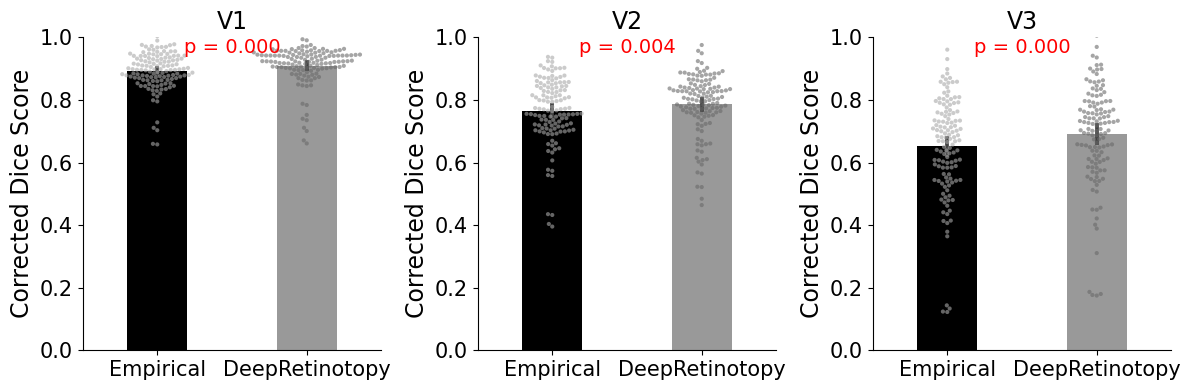

lh
TtestResult(statistic=1.0420526783737176, pvalue=0.3013696746835263, df=63)
No significant results
Segmentation performance for V1
Empirical: 0.9281399941534744 +- 0.03587688227877791
DeepRetinotopy: 0.9210183783215867 +- 0.05360061052285155
TtestResult(statistic=0.96961621625676, pvalue=0.33594572970179915, df=63)
No significant results
Segmentation performance for V2
Empirical: 0.8142786440016254 +- 0.07146024519924488
DeepRetinotopy: 0.8031540733335112 +- 0.08063868898957403
TtestResult(statistic=-0.34195874439591234, pvalue=0.7335200580837182, df=63)
No significant results
Segmentation performance for V3
Empirical: 0.7648847573759511 +- 0.10530088944497791
DeepRetinotopy: 0.7696697079375105 +- 0.13205425597809228


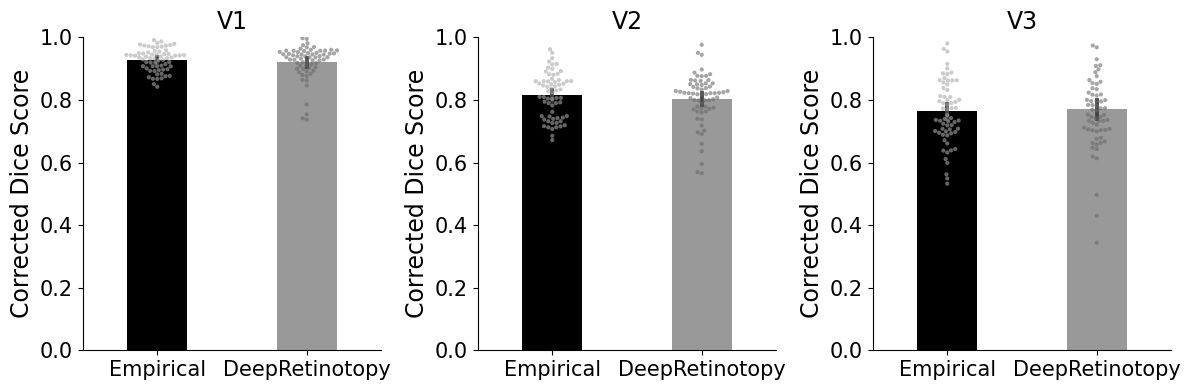

rh
TtestResult(statistic=-12.190773061702666, pvalue=3.1551267590576823e-18, df=63)
Segmentation performance for V1
Empirical: 0.8582090971725685 +- 0.05990874283639125
DeepRetinotopy: 0.8987912455753087 +- 0.06583989031389349
TtestResult(statistic=-11.04401248056682, pvalue=2.254779005330936e-16, df=63)
Segmentation performance for V2
Empirical: 0.7192051055112934 +- 0.11357449950169073
DeepRetinotopy: 0.7691920030312305 +- 0.10652374447752065
TtestResult(statistic=-12.674365969476293, pvalue=5.473400236248241e-19, df=63)
Segmentation performance for V3
Empirical: 0.5461773913221077 +- 0.14717045329709724
DeepRetinotopy: 0.6179625709086669 +- 0.15899097664261833


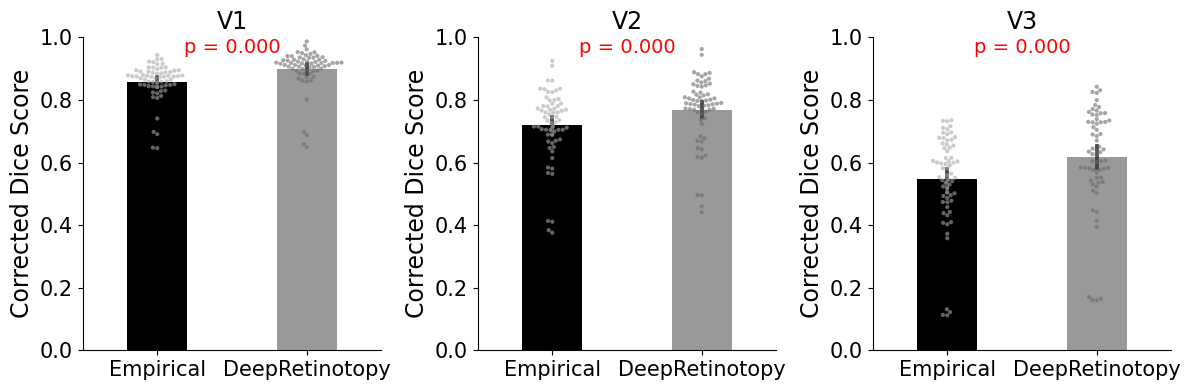

In [25]:
# Barplots of dice scores
def create_barplots(df_automated_vs_manual, df_anatomists, hemisphere = 'both'):
    output_dir = './../output/segmentation/'
    if os.path.exists(output_dir) is False:
            os.makedirs(output_dir)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for i, area in enumerate(vareas):
        plt.sca(axes[i])

        if hemisphere == 'both':
            # automated vs manual
            results_method = df_automated_vs_manual[(df_automated_vs_manual['area'] == area)]
            for sub in results_method['subject'].unique():
                sub_mean_annotators = df_anatomists[(df_anatomists['area'] == area) & (df_anatomists['subject'] == sub)]['dice_score'].mean()
                results_method.loc[results_method['subject'] == sub, 'dice_score'] = results_method.loc[results_method['subject'] == sub, 'dice_score'] / sub_mean_annotators
        else:
            # automated vs manual
            results_method = df_automated_vs_manual[(df_automated_vs_manual['area'] == area) & (df_automated_vs_manual['hemisphere'] == hemisphere)] 
            for sub in results_method['subject'].unique():
                sub_mean_annotators = df_anatomists[(df_anatomists['area'] == area) & (df_anatomists['hemisphere'] == hemisphere) & (df_anatomists['subject'] == sub)]['dice_score'].mean()
                results_method.loc[results_method['subject'] == sub, 'dice_score'] = results_method.loc[results_method['subject'] == sub, 'dice_score'] / sub_mean_annotators
        sns.barplot(data=results_method, y='dice_score', x="group", errorbar=('ci', 95), ax=axes[i], palette= ["#000000ff", '#999999ff',], linewidth= 3, width=0.4)
        sns.swarmplot(data=results_method, y='dice_score', x="group", palette=['darkgray','dimgray'], size=3, ax=axes[i], alpha=0.6, hue="group", legend=False)

        # two-tailed ttest
        alpha = 0.025
        ttest = scipy.stats.ttest_rel(results_method['dice_score'][results_method['group']=='empirical'], results_method['dice_score'][results_method['group']=='deepRetinotopy'])
        print(ttest)
        if np.abs(ttest.pvalue) < alpha:
            plt.text(0.5, 0.95, f'p = {ttest.pvalue:.3f}', transform=axes[i].transAxes, ha='center', fontsize=14, color='red')
        else: 
            print('No significant results')

        # print some stats
        print(f'Segmentation performance for V{area}')
        print(f"Empirical: {results_method['dice_score'][results_method['group']=='empirical'].mean()} +- {results_method['dice_score'][results_method['group']=='empirical'].std()}")
        print(f"DeepRetinotopy: {results_method['dice_score'][results_method['group']=='deepRetinotopy'].mean()} +- {results_method['dice_score'][results_method['group']=='deepRetinotopy'].std()}")

        axes[i].set_title(f'V{area}', fontsize=17)
        axes[i].set_ylim(0, 1)

        plt.ylabel("Corrected Dice Score", fontsize=17)
        plt.xlabel("")
        plt.xticks([0, 1], ['Empirical', 'DeepRetinotopy'], fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlim(-0.5, 1.5)
        plt.ylim(0, 1) 
        plt.tight_layout()
        sns.despine()
        plt.savefig(f'{output_dir}corrected_dice_score_across_visual_areas_{hemisphere}.pdf', dpi=300)
    return plt.show()

for hemisphere in ['both', 'lh', 'rh']:
    print(hemisphere)
    create_barplots(df_automated_vs_manual, df_anatomists, hemisphere = hemisphere)


Note that the following cell will generate alternative bar plots where the gray shaded area represents the noise ceiling, i.e., the 95% confidence interval of the DICE scores between all pairs of manual annotations, across anatomists and participants, as shown in Supplementary Figure 5 and 6.

both
TtestResult(statistic=-3.8232168112528497, pvalue=0.00020536021653079606, df=127)
Segmentation performance for V1
Empirical: 0.8338290879495167 +- 0.06115599117392136
DeepRetinotopy: 0.8493862498015077 +- 0.060854963633023756
TtestResult(statistic=-2.9564081618937705, pvalue=0.003711805688926138, df=127)
Segmentation performance for V2
Empirical: 0.6754347138121175 +- 0.09473156970646616
DeepRetinotopy: 0.692968198607484 +- 0.08945259129026749
TtestResult(statistic=-5.190350186143814, pvalue=8.086831167254489e-07, df=127)
Segmentation performance for V3
Empirical: 0.5530439836935401 +- 0.13468576679760838
DeepRetinotopy: 0.5867923018663863 +- 0.13384575748442512


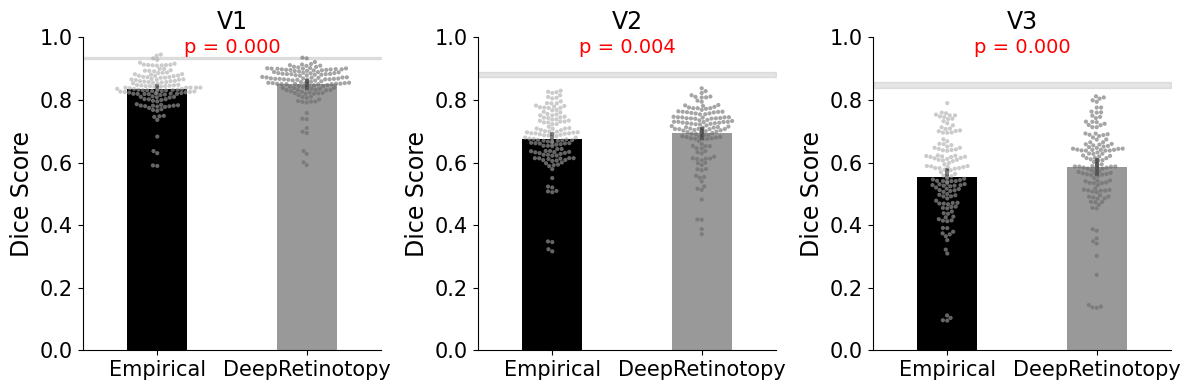

lh
TtestResult(statistic=1.054817816300912, pvalue=0.2955371960276308, df=63)
No significant results
Segmentation performance for V1
Empirical: 0.8674731898510929 +- 0.040075237106050064
DeepRetinotopy: 0.8606999020188 +- 0.05301462843795476
TtestResult(statistic=0.9284635556885389, pvalue=0.35671089856585303, df=63)
No significant results
Segmentation performance for V2
Empirical: 0.7137514808240516 +- 0.07146610841932209
DeepRetinotopy: 0.7043612962471715 +- 0.08153149237045146
TtestResult(statistic=-0.4621266964487232, pvalue=0.6455824593588569, df=63)
No significant results
Segmentation performance for V3
Empirical: 0.6322454578960267 +- 0.08998658312926709
DeepRetinotopy: 0.6373017016837609 +- 0.11127906318905452


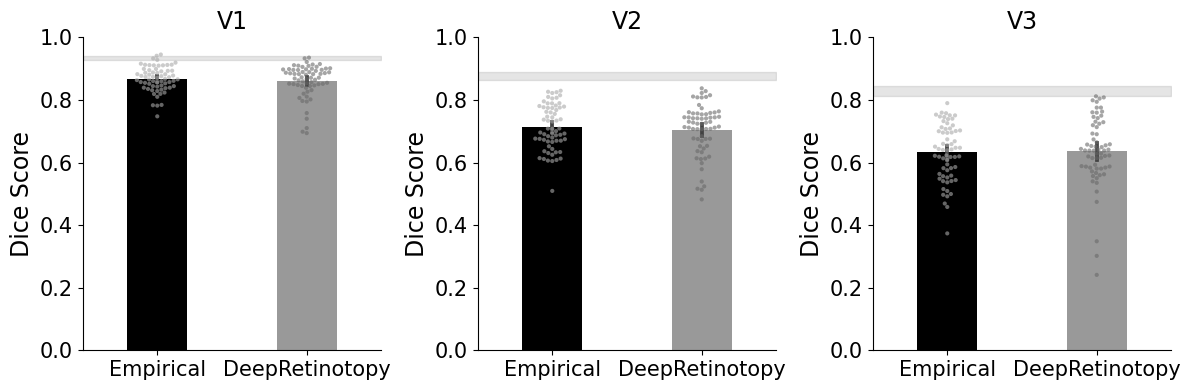

rh
TtestResult(statistic=-12.168848867060898, pvalue=3.418293055147092e-18, df=63)
Segmentation performance for V1
Empirical: 0.8001849860479404 +- 0.060279901368083526
DeepRetinotopy: 0.8380725975842156 +- 0.06629347197425871
TtestResult(statistic=-10.941510881590533, pvalue=3.327545331543917e-16, df=63)
Segmentation performance for V2
Empirical: 0.6371179468001833 +- 0.10000111758756006
DeepRetinotopy: 0.6815751009677966 +- 0.09601788386342913
TtestResult(statistic=-12.587308348015421, pvalue=7.486242441952579e-19, df=63)
Segmentation performance for V3
Empirical: 0.47384250949105333 +- 0.12540327390811726
DeepRetinotopy: 0.5362829020490116 +- 0.13618852520540276


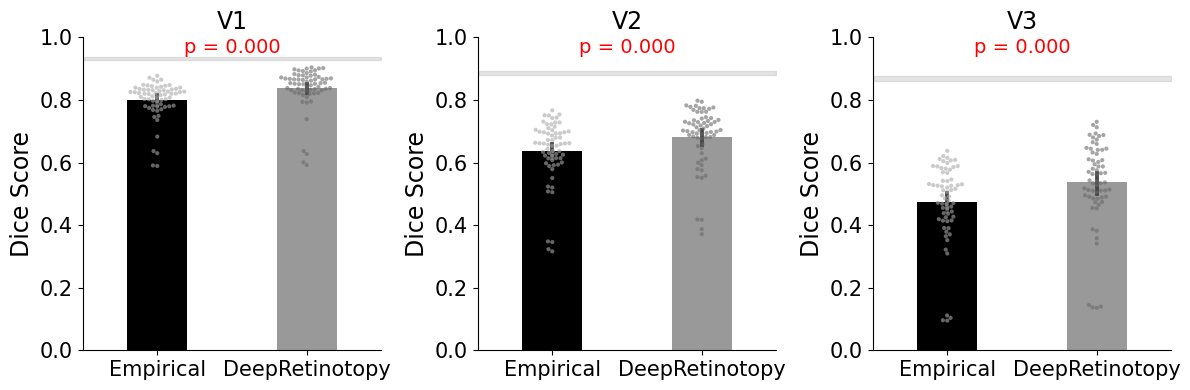

In [27]:
# Barplots of dice scores
def create_barplots_with_noise_ceiling(df_automated_vs_manual, df_anatomists, hemisphere = 'both'):
    output_dir = './../output/segmentation/'
    if os.path.exists(output_dir) is False:
            os.makedirs(output_dir)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for i, area in enumerate(vareas):
        plt.sca(axes[i])

        if hemisphere == 'both':
            # automated vs manual
            results_method = df_automated_vs_manual[(df_automated_vs_manual['area'] == area)]
            # manual
            mean_anatomist = df_anatomists[(df_anatomists['area'] == area)]['dice_score'].mean()
            std_anatomist = df_anatomists[(df_anatomists['area'] == area)]['dice_score'].std()
            se_anatomist = std_anatomist / np.sqrt(len(df_anatomists[(df_anatomists['area'] == area)]))
        else:
            # automated vs manual
            results_method = df_automated_vs_manual[(df_automated_vs_manual['area'] == area) & (df_automated_vs_manual['hemisphere'] == hemisphere)] 
            # manual
            mean_anatomist = df_anatomists[(df_anatomists['area'] == area) & (df_anatomists['hemisphere'] == hemisphere)]['dice_score'].mean()
            std_anatomist = df_anatomists[(df_anatomists['area'] == area) & (df_anatomists['hemisphere'] == hemisphere)]['dice_score'].std()
            se_anatomist = std_anatomist / np.sqrt(len(df_anatomists[(df_anatomists['area'] == area) & (df_anatomists['hemisphere'] == hemisphere)]))
        
        sns.barplot(data=results_method, y='dice_score', x="group", errorbar=('ci', 95), ax=axes[i], palette= ["#000000ff", '#999999ff',], linewidth= 3, width=0.4)
        sns.swarmplot(data=results_method, y='dice_score', x="group", palette=['darkgray','dimgray'], hue='group', size=3, ax=axes[i], alpha=0.6, legend=False)

        # two-tailed ttest
        alpha = 0.025
        ttest = scipy.stats.ttest_rel(results_method['dice_score'][results_method['group']=='empirical'], results_method['dice_score'][results_method['group']=='deepRetinotopy'])
        print(ttest)
        if np.abs(ttest.pvalue) < alpha:
            plt.text(0.5, 0.95, f'p = {ttest.pvalue:.3f}', transform=axes[i].transAxes, ha='center', fontsize=14, color='red')
        else: 
            print('No significant results')

        # print some stats
        print(f'Segmentation performance for V{area}')
        print(f"Empirical: {results_method['dice_score'][results_method['group']=='empirical'].mean()} +- {results_method['dice_score'][results_method['group']=='empirical'].std()}")
        print(f"DeepRetinotopy: {results_method['dice_score'][results_method['group']=='deepRetinotopy'].mean()} +- {results_method['dice_score'][results_method['group']=='deepRetinotopy'].std()}")

        axes[i].set_title(f'V{area}', fontsize=17)
        axes[i].set_ylim(0, 1)
        # axes[i].legend_.remove() 

        plt.fill_between([-0.5, 1.5], mean_anatomist - se_anatomist * 1.96, mean_anatomist + se_anatomist * 1.96, alpha=0.2, color='gray')
        plt.ylabel("Dice Score", fontsize=17)
        plt.xlabel("")
        plt.xticks([0, 1], ['Empirical', 'DeepRetinotopy'], fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlim(-0.5, 1.5)
        plt.ylim(0, 1) 
        plt.tight_layout()
        sns.despine()
        plt.savefig(f'{output_dir}dice_score_across_visual_areas_{hemisphere}.pdf', dpi=300)
    return plt.show()

for hemisphere in ['both', 'lh', 'rh']:
    print(hemisphere)
    create_barplots_with_noise_ceiling(df_automated_vs_manual, df_anatomists, hemisphere = hemisphere)


## 5. Influence of weight on the Bayesian inference

We estimated the impact of the weighting on the automatic estimation of the visual area labels by using an alternative weight map with ones everywhere (maximum weight to the observation), Supplementary Figure 9.

TtestResult(statistic=-8.013268636215644, pvalue=6.236821605351314e-13, df=127)
Mean from mean variance explained weight map: 0.8493862498015077
Mean from ones weight map:0.8430957688699787
TtestResult(statistic=-7.758131849244597, pvalue=2.4576522901552423e-12, df=127)
Mean from mean variance explained weight map: 0.692968198607484
Mean from ones weight map:0.6841548901160371
TtestResult(statistic=-8.54104162828396, pvalue=3.5120831137960925e-14, df=127)
Mean from mean variance explained weight map: 0.5867923018663863
Mean from ones weight map:0.5733112108039433


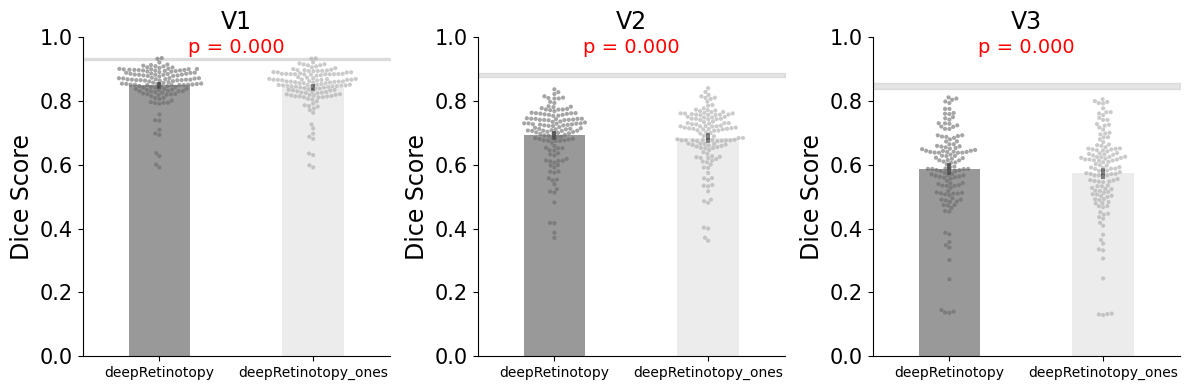

TtestResult(statistic=-1.935015867794994, pvalue=0.05748054074992715, df=63)
No significant results
Mean from mean variance explained weight map: 0.8606999020188
Mean from ones weight map:0.85912621993626
TtestResult(statistic=-2.0841065121281024, pvalue=0.04121149044918023, df=63)
No significant results
Mean from mean variance explained weight map: 0.7043612962471715
Mean from ones weight map:0.7015208915308421
TtestResult(statistic=-1.9352062462556796, pvalue=0.0574566953606057, df=63)
No significant results
Mean from mean variance explained weight map: 0.6373017016837609
Mean from ones weight map:0.635321690328621


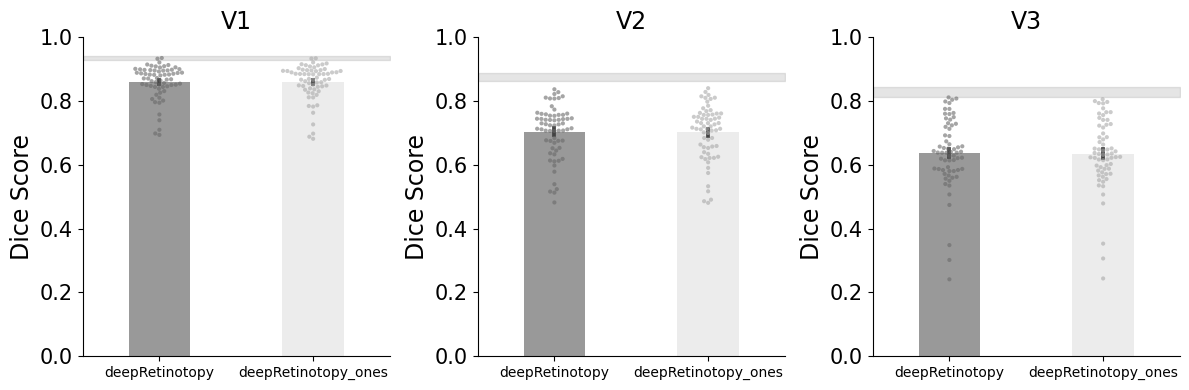

TtestResult(statistic=-10.415693449545829, pvalue=2.4954247025737626e-15, df=63)
Mean from mean variance explained weight map: 0.8380725975842156
Mean from ones weight map:0.8270653178036973
TtestResult(statistic=-9.939510460823234, pvalue=1.5864293281862732e-14, df=63)
Mean from mean variance explained weight map: 0.6815751009677966
Mean from ones weight map:0.6667888887012321
TtestResult(statistic=-11.404766679748917, pvalue=5.78680853663082e-17, df=63)
Mean from mean variance explained weight map: 0.5362829020490116
Mean from ones weight map:0.5113007312792656


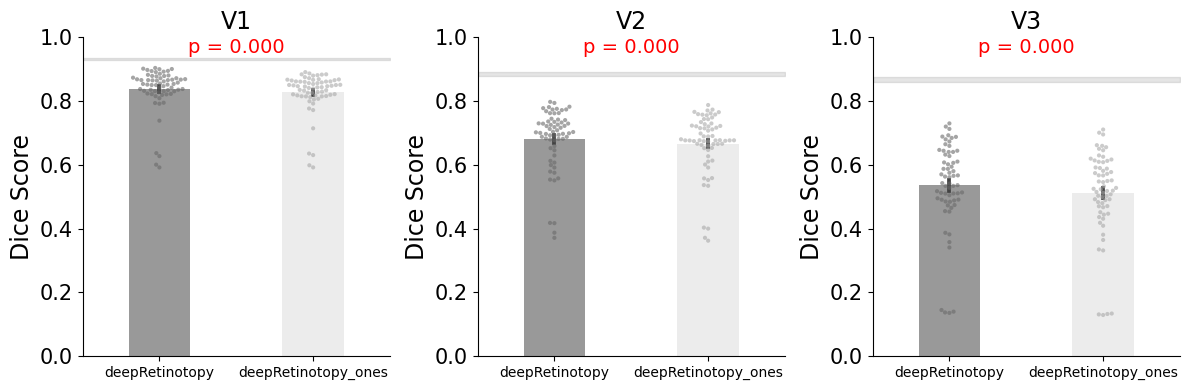

In [28]:
df_automated_vs_manual = create_dataframe_automated_vs_manual(dice_empirical, dice_deepret, dice_deepret_ones)
df_anatomists = create_dataframe_manual_vs_manual(dice_anatomist_anotimist)

# Barplots of dice scores
def create_barplots(df_automated_vs_manual, df_anatomists, hemisphere = 'both'):
    output_dir = './../output/segmentation/'
    if os.path.exists(output_dir) is False:
            os.makedirs(output_dir)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for i, area in enumerate(vareas):
        plt.sca(axes[i])

        if hemisphere == 'both':
            # automated vs manual
            results_method = df_automated_vs_manual[(df_automated_vs_manual['area'] == area)]
            # manual
            mean_anatomist = df_anatomists[(df_anatomists['area'] == area)]['dice_score'].mean()
            std_anatomist = df_anatomists[(df_anatomists['area'] == area)]['dice_score'].std()
            se_anatomist = std_anatomist / np.sqrt(len(df_anatomists[(df_anatomists['area'] == area)]))
        else:
            # automated vs manual
            results_method = df_automated_vs_manual[(df_automated_vs_manual['area'] == area) & (df_automated_vs_manual['hemisphere'] == hemisphere)] 
            # manual
            mean_anatomist = df_anatomists[(df_anatomists['area'] == area) & (df_anatomists['hemisphere'] == hemisphere)]['dice_score'].mean()
            std_anatomist = df_anatomists[(df_anatomists['area'] == area) & (df_anatomists['hemisphere'] == hemisphere)]['dice_score'].std()
            se_anatomist = std_anatomist / np.sqrt(len(df_anatomists[(df_anatomists['area'] == area) & (df_anatomists['hemisphere'] == hemisphere)]))
        
        # two-tailed ttest
        alpha = 0.025
        ttest = scipy.stats.ttest_rel(results_method['dice_score'][results_method['group']=='deepRetinotopy_ones'], results_method['dice_score'][results_method['group']=='deepRetinotopy'])
        print(ttest)
        if np.abs(ttest.pvalue) < alpha:
            plt.text(0.5, 0.95, f'p = {ttest.pvalue:.3f}', transform=axes[i].transAxes, ha='center', fontsize=14, color='red')
        else: 
            print('No significant results')
        print(f"Mean from mean variance explained weight map: {np.mean(results_method['dice_score'][results_method['group']=='deepRetinotopy'])}")
        print(f"Mean from ones weight map:{np.mean(results_method['dice_score'][results_method['group']=='deepRetinotopy_ones'])}")
        
        sns.barplot(data=results_method, y='dice_score', x="group", errorbar='se', ax=axes[i], palette=['#999999ff', '#ecececff'], linewidth= 3, width=0.4)
        sns.swarmplot(data=results_method, y='dice_score', x="group", palette=['dimgray','darkgray'], hue='group', size=3, ax=axes[i], alpha=0.6, legend=False)
        axes[i].set_title(f'V{area}', fontsize=17)
        axes[i].set_ylim(0, 1)
        # axes[i].legend_.remove() 

        plt.fill_between([-0.5, 1.5], mean_anatomist - se_anatomist * 1.96, mean_anatomist + se_anatomist * 1.96, alpha=0.2, color='gray')
        plt.ylabel("Dice Score", fontsize=17)
        plt.xlabel("")
        # plt.xticks([0, 1], ['Empirical', 'DeepRetinotopy'], fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlim(-0.5, 1.5)
        plt.ylim(0, 1) 
        plt.tight_layout()
        sns.despine()
        plt.savefig(f'{output_dir}dice_score_as_function_of_weight_across_visual_areas_{hemisphere}.pdf', dpi=300)
    return plt.show()

for hemisphere in ['both', 'lh', 'rh']:
    create_barplots(df_automated_vs_manual, df_anatomists, hemisphere = hemisphere)